In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pylab as plt
%matplotlib inline

input_path="/Users/phuph/Desktop/PROJECT COTTON/Headcount.csv"
df = pd.read_csv(input_path)


C:\Users\phuph\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df.describe(include='all')

,Date,Production Volume,Centred moving means,ISE,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
count,33,33.000000,28.000000,28.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,7.000000
unique,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN
top,01/05/2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AVERAGE SEASONAL EFFECT,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
mean,NaN,95276.303021,108038.108621,-1952.742560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2829.651786
std,NaN,49775.913111,45230.245063,7067.766573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4117.736196
min,NaN,12642.750000,39996.250000,-16810.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8094.645833
25%,NaN,54424.750000,65382.250000,-6520.625000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5659.583334
50%,NaN,89576.000000,105415.750000,-2796.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3003.000000
75%,NaN,144039.000000,150633.708350,3332.375000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-498.208333


In [4]:
product_forecast = df[['Date','Production Volume']]
product_forecast= product_forecast.rename(columns={"Production Volume":"volume"})
product_forecast[:5]

,Date,volume
0,01/01/2012,12642.75
1,01/02/2012,27017.75
2,01/03/2012,38135.75
3,01/04/2012,54424.75
4,01/05/2012,41506.75


In [5]:
product_forecast['Date'] = pd.to_datetime(product_forecast['Date'],format='%d/%m/%Y')


In [6]:
#Change product date to the right format and set as index
product_forecast['index']= product_forecast['Date']
product_forecast.set_index(['index'], inplace=True)
product_forecast.index.name=None
product_forecast.drop('Date',axis=1)

,volume
2012-01-01,12642.7500
2012-02-01,27017.7500
2012-03-01,38135.7500
2012-04-01,54424.7500
2012-05-01,41506.7500
2012-06-01,52301.7500
2012-07-01,50221.7500
2012-08-01,43886.7500
2012-09-01,36105.7500
2012-10-01,59070.7500


In [7]:
#Check stationary
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput )


C:\Users\phuph\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
C:\Users\phuph\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


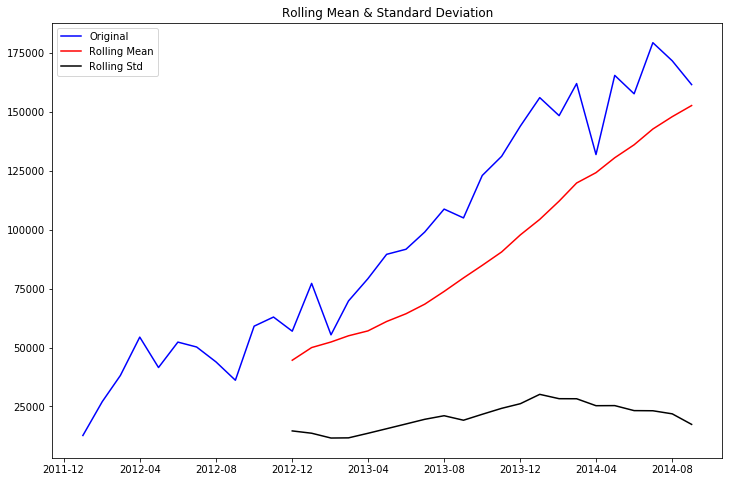

Results of Dickey-Fuller Test:
Test Statistic                 -0.649710
p-value                         0.859350
#Lags Used                      7.000000
Number of Observations Used    25.000000
Critical Value (10%)           -2.632800
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
dtype: float64


In [8]:
test_stationarity(product_forecast.volume)

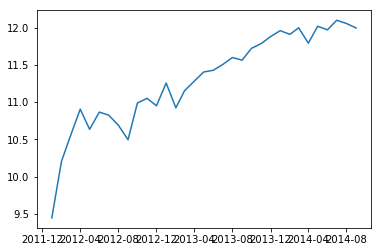

In [9]:
# Estimate and Eliminate trend through log transformation
ts_log = np.log(product_forecast.volume)
plt.plot(ts_log)

C:\Users\phuph\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,halflife=12,adjust=True,min_periods=0).mean()
  


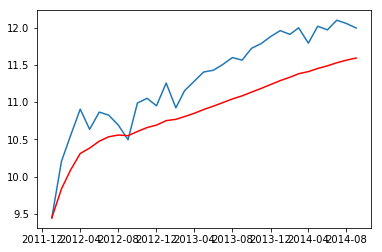

In [10]:
#USING EXPONENTIAL MOVING AVERAGE where weights are assigned to all the previous values with a decay factor
expwighted_avg = pd.ewma(ts_log, halflife=12)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

C:\Users\phuph\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
C:\Users\phuph\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


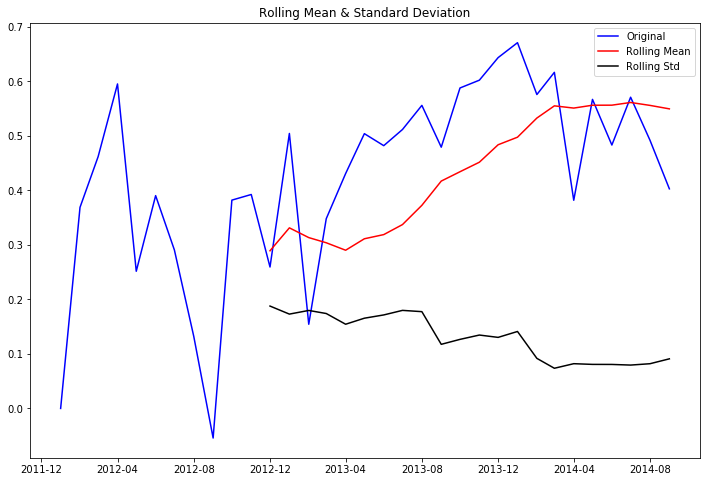

Results of Dickey-Fuller Test:
Test Statistic                 -1.144746
p-value                         0.696902
#Lags Used                      7.000000
Number of Observations Used    25.000000
Critical Value (10%)           -2.632800
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
dtype: float64


In [11]:
#Minus the exponential average to get variance
ts_log_exp_diff =ts_log - expwighted_avg
ts_log_exp_diff.dropna(inplace=True)
test_stationarity(ts_log_exp_diff)

C:\Users\phuph\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
C:\Users\phuph\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


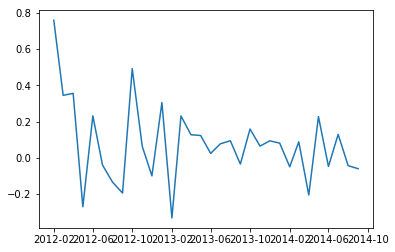

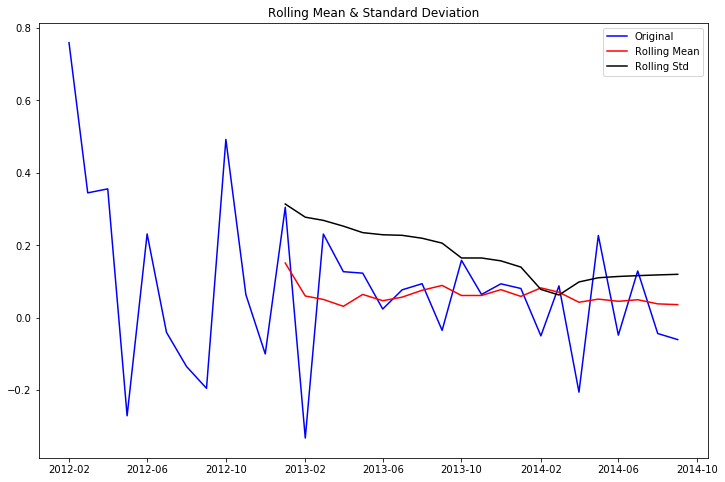

Results of Dickey-Fuller Test:
Test Statistic                 -3.170841
p-value                         0.021736
#Lags Used                      6.000000
Number of Observations Used    25.000000
Critical Value (10%)           -2.632800
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
dtype: float64


In [81]:
# Differencing smoothing
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

C:\Users\phuph\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=6,center=False).mean()
  
C:\Users\phuph\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
C:\Users\phuph\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


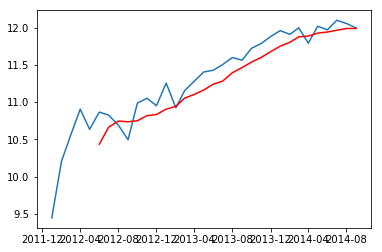

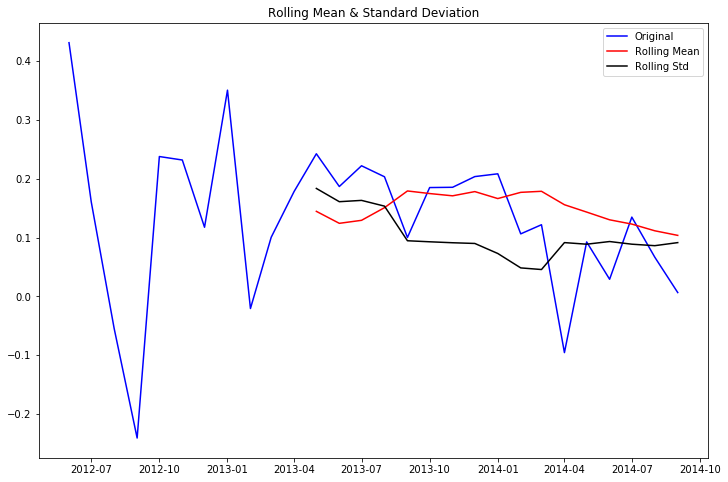

Results of Dickey-Fuller Test:
Test Statistic                 -4.787701
p-value                         0.000057
#Lags Used                      0.000000
Number of Observations Used    27.000000
Critical Value (10%)           -2.627601
Critical Value (1%)            -3.699608
Critical Value (5%)            -2.976430
dtype: float64


In [13]:
#Option1  Moving average
moving_avg = pd.rolling_mean(ts_log,6)
plt.plot(ts_log)
plt.plot(moving_avg,color='red')
ts_log_moving_avg_diff =ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

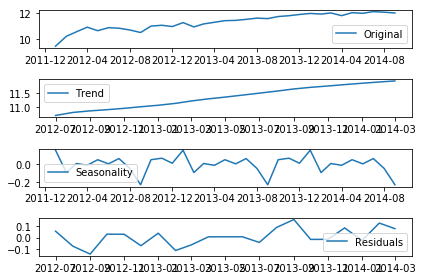

In [41]:
#Eliminate trend using Seasonality
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

C:\Users\phuph\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
C:\Users\phuph\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


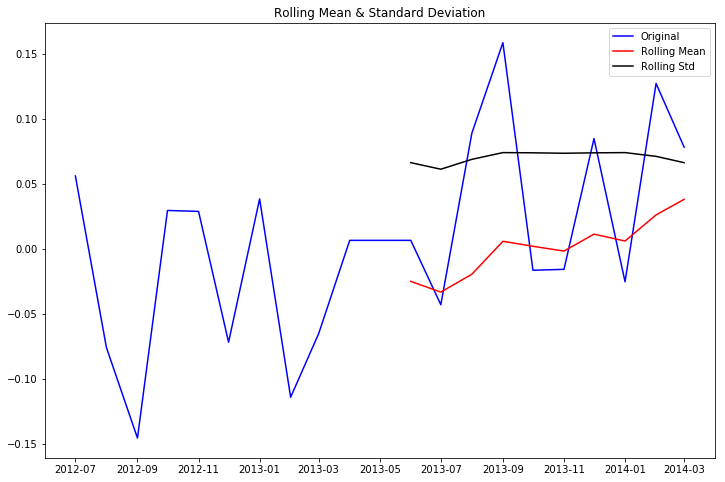

Results of Dickey-Fuller Test:
Test Statistic                 -0.000000
p-value                         0.958532
#Lags Used                      9.000000
Number of Observations Used    11.000000
Critical Value (10%)           -2.729839
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
dtype: float64


C:\Users\phuph\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1353: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [42]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

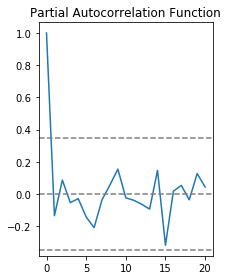

In [57]:
#PACF
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

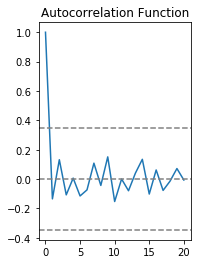

In [58]:
#Plot ACF:
lag_acf = acf(ts_log_diff, nlags=20)
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

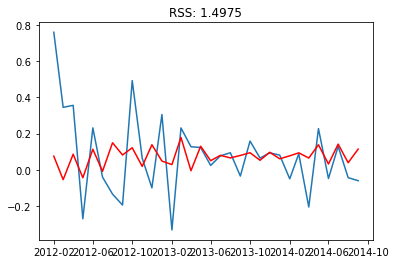

In [82]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log, order=(3,1,0))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plt.figure(figsize=(25,10))


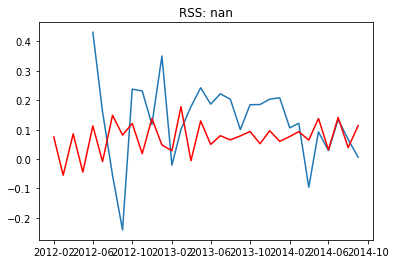

In [20]:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_moving_avg_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_moving_avg_diff)**2))


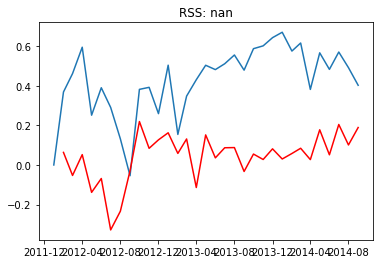

In [112]:
model = ARIMA(ts_log, order=(6,1,0))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_exp_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_exp_diff)**2))
plt.figure(figsize=(25,10))

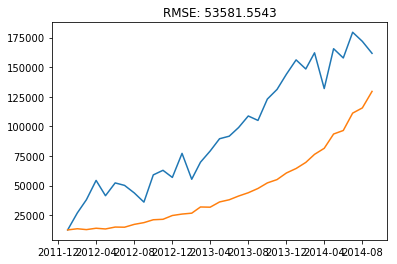

In [79]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(product_forecast.volume)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-product_forecast.volume)**2)/len(product_forecast.volume)))